<img src="../img/GTK_Logo_Social Icon.jpg" width=175 align="right" />


# Worksheet 6.0 Clustering - Answers

This worksheet covers concepts relating to Unsupervised Learning.  It should take no more than 20-30 minutes to complete.  Please raise your hand if you get stuck.  

There are many ways to accomplish the tasks that you are presented with, however you will find that by using the techniques covered in class, the exercises should be relatively simple. 

In [45]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
style.use("ggplot")

# Clustering with Real Data
Let's try it on some real data and see what we can produce. As before the first step is to read in the data into a DataFrame.  

We will be using this data later, but the dataset consists of approximately 6000 domains--5000 of which were generated by various botnets and 1000 are from the Alexa 1 Million.  The columns are:

* `dsrc`:  The source of the domain
* `domain`:  The actual domain
* `length`:  The length of the domain
* `dicts`:  Percentage containing dictionary words
* `entropy`:  The entropy of the domain
* `numbers`:  The number of digits in the domain
* `ngram`:  Different n-grams which appear in the domain (?)

In [3]:
data = pd.read_csv('../data/dga-full.csv')
data.sample(5)

,dsrc,domain,length,dicts,entropy,numbers,ngram
40205,nivdort,roomeight,9,1.000000,2.947703,0,11.371083
30559,necurs,gdgyfrsgblxkddni,16,0.625000,3.405639,0,0.954243
1796,bamital,0c17e4c3c78a4cddbe617efc40a21c3a,32,0.125000,3.584868,16,0.000000
37002,nivdort,signwild,8,1.000000,2.750000,0,5.871186
17161,gameoverdga,1pnb521u25xt01xxe8mi1jeyzm0,27,0.111111,3.912114,11,0.000000


In [4]:
data['dsrc'].value_counts()

dsrc
cryptolocker    10000
gameoverdga     10000
necurs          10000
alexa           10000
nivdort          9978
bamital          2500
Name: count, dtype: int64

## Scaling the Data
Since clustering relies on measuring distances between objects it is important that all data points be on the same scale.  There are various methods for doing this, which are beyond the scope of this class, however, for this example, we will use scikit-learn's `StandardScaler` to accomplish this.  (http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

The StandardScaler transforms each column by:
* Subtracting from the element in each row the mean for each feature (column) and then taking this value and
* Dividing by that feature's (column's) standard deviation.

Scikit-learn has a transformer interface which is very similar to the other scikit-learn interfaces.  The basic steps are:
1.  Create the Scaler object
2.  Using the feature matrix, call the `.fit()` method to "train" the Scaler
3.  Use the `.transform()` method to scale the data.

**NOTE**: When using a Scaler, it is important to train the scaler on your data, and use this trained scalers on any future predictions. 

In [5]:
feature_columns = ['length', 'dicts','entropy','numbers','ngram']
scaled_feature_columns = ['scaled_length', 'scaled_dicts','scaled_entropy','scaled_numbers','scaled_ngram']

In [6]:
#Step 1:  Create the scaler
scaler = StandardScaler()

#Steps 2 & 3:  Fit the scaler and transform this data
scaled_df = scaler.fit_transform(data[feature_columns])

#Put the scaled data into a dataframe
scaled_df = pd.DataFrame(scaled_df, columns=scaled_feature_columns)

Take a look at the data and you'll see that the data is now all scaled consistently. 

In [7]:
scaled_df.sample(10)

,scaled_length,scaled_dicts,scaled_entropy,scaled_numbers,scaled_ngram
20415,1.429253,-0.864455,1.236128,1.020643,-0.538057
35711,-0.933453,1.144799,-1.265204,-0.498385,0.034026
34486,-0.933453,1.144799,-0.833959,-0.498385,0.601493
30586,-0.014622,0.411597,-0.305141,-0.498385,-0.440772
24973,-0.145884,0.948405,-0.335183,-0.498385,0.222127
31884,0.772946,0.490155,1.341872,-0.498385,-0.113267
47581,-1.064714,0.752012,-1.227875,-0.498385,0.185877
43698,-1.064714,1.144799,-1.227875,-0.498385,0.326269
321,2.216822,-1.346940,0.358741,3.678940,-0.540909
24445,-0.933453,0.113734,-0.833959,-0.498385,-0.722434


Finally for convenience, we're going to merge the scaled features with the unscaled features.  

In [10]:
final_data = pd.merge( data, scaled_df, left_index=True, right_index=True)

In [11]:
final_data.sample(5)

,dsrc,domain,length,dicts,entropy,numbers,ngram,scaled_length,scaled_dicts,scaled_entropy,scaled_numbers,scaled_ngram
19742,gameoverdga,8illr7dkjtoegh3ahe180xu9e,25,0.360000,4.213661,7,3.255273,1.297992,-0.614884,1.690828,0.830764,-0.202552
6635,cryptolocker,iuyjgibqbfbsn,13,0.461538,3.180833,0,0.000000,-0.277145,-0.335704,-0.090780,-0.498385,-0.811719
4962,cryptolocker,apeixyociejw,12,0.666667,3.251629,0,3.041393,-0.408407,0.228297,0.031342,-0.498385,-0.242576
24513,necurs,qgulxgks,8,0.750000,2.750000,0,0.477121,-0.933453,0.457423,-0.833959,-0.498385,-0.722434
50766,alexa,spanch-bob,10,0.800000,3.121928,0,7.339920,-0.670930,0.594898,-0.192390,-0.498385,0.561817


### Your Turn!
Now that we have data that is suitable (maybe) for clustering, in the section below, perform K-Means clustering on this data set.  Initially, start out with 2 clusters and assign the `cluster id` as a column in your DataFrame.

Then do a `value_counts()` on the `dsrc` column for each cluster to see how the model divided the data.  Try various values for `k` to see how it performed.

Remember to use the **scaled features** for your clustering.  

In [12]:
kmeans = KMeans(n_clusters=2, n_init=2).fit(final_data[scaled_feature_columns])

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print(centroids)
print(labels)

[[ 1.56899145 -1.17177795  1.22510555  1.5429584  -0.63406745]
 [-0.49760996  0.3716326  -0.3885456  -0.4893535   0.20109624]]
[0 0 0 ... 1 1 1]


In [13]:
final_data['dsrc'].value_counts()

dsrc
cryptolocker    10000
gameoverdga     10000
necurs          10000
alexa           10000
nivdort          9978
bamital          2500
Name: count, dtype: int64

In [14]:
final_data['cluster_id'] = kmeans.labels_

In [15]:
final_data['dsrc'].value_counts()

dsrc
cryptolocker    10000
gameoverdga     10000
necurs          10000
alexa           10000
nivdort          9978
bamital          2500
Name: count, dtype: int64

In [16]:
final_data[final_data['cluster_id'] == 1]['dsrc'].value_counts()

dsrc
cryptolocker    10000
alexa            9997
nivdort          9978
necurs           9860
gameoverdga         7
Name: count, dtype: int64

In [17]:
final_data[final_data['cluster_id'] == 1]['domain'].sample(15)

23513          ifyhraqnxnrr
33494             takenrule
50450                4proxy
11111        rcldfhwflfqlql
37948             hairseven
32852              jumpnice
43496                 miami
42984            iptorrents
51762          madaresegypt
45467                   sfu
27018    lnwevifddpsgleffjd
39886      signconsiderable
11688          daidaswmakqx
38160             spendlate
25462       juovqxljcflknye
Name: domain, dtype: object

In [18]:
final_data[final_data['cluster_id'] == 0]['domain'].sample(15)

19687         17yysk51csn7b8ehf0b81niwq0x
21365           1wljdcon2xwmhoxgxrxk17hhr
16690          j4b4j817cqs75py33el1dkngvb
17238         1m0wzd887kk8j1hnh2m010s1xdz
16726           1cvfn615xvq7e709p7we9vsrw
21043           2fftb0xhezkc1k6iz1fyirocv
14348         1pxpyb01x6w3ev1bnjwa0cbvao3
1231     0529c4160efb127cfd55b7b5ed24ec55
964      8c97c1880d40a1c7e8cdbbcafe4e8231
17231            fplfzcnv7wtzbzrrpry35jro
475      e0b48ba8936eb5015aca656876a9876d
14792           175iosdw7imlfkumk5rpwyhql
13995          19pob9k188iffirjnoxz8y1r9n
18070            evehb8gnyezs6kv0tg8w9iva
27393               swpvdjeibgxxljfwyptvn
Name: domain, dtype: object

In [19]:
final_data['domain'][final_data['dsrc'] == 'cryptolocker'].sample(5)

11720      oomacvtsyywo
4881       xsjerawxohce
9495     dioryhgpvlyujd
6921       nrqkekqdlnga
5556      cenwdjhwvyvos
Name: domain, dtype: object

In [20]:
final_data[final_data['dsrc'] == "bamital"]['domain'].sample(10)

2232    f21be367eb9eec290354aba505441057
918     6501933f3dfa6a48ead30e470ad0948b
2280    9390c4b37ee0579ec9a312270f9779c6
1061    86875ab052d0d4a0d1d33fdfd617a009
753     2766e79f1d2a3a2f5fb90b43fd9dc056
448     a7515914e527cb1a9fca2cb09d0ad1df
1130    75b48c54c89bcc01a84b002f60382774
2445    92beea469b07f53e0a72a702efc88b3f
1389    8d69a9bb7a5cf7a70ddb7162cd351171
1160    b66c39405a9ba03153d0d83b0bf7249f
Name: domain, dtype: object

In [21]:
final_data[final_data['dsrc'] == "nivdort"]['domain'].sample(10)

36234         sightgrow
38718         southhelp
37024          whomkind
34230          thistalk
33925          yardmoon
41643        watchgreen
37171         drinkfind
37854    septemberraise
33052          whomgift
38009         humandare
Name: domain, dtype: object

In [22]:
final_data[(final_data['cluster_id'] == 1) & (final_data['dsrc'] == 'necurs')]['domain']

22500       aqpoesogafvwyvlog
22501                 iwxdakv
22502            qwotyugasduc
22503          fywbpebyvhgbov
22504          lwmgjqvhpwiabx
                 ...         
32495                chdxyfak
32496             upgclshimcu
32497                ygtwdecs
32498    jcbwowxlmhpawfuwfjyn
32499                 vpvlyut
Name: domain, Length: 9860, dtype: object

In [23]:
final_data.sample(5)

,dsrc,domain,length,dicts,entropy,numbers,ngram,scaled_length,scaled_dicts,scaled_entropy,scaled_numbers,scaled_ngram,cluster_id
38319,nivdort,watchcity,9,1.000000,2.725481,0,11.451684,-0.802191,1.144799,-0.876255,-0.498385,1.331261,1
42465,nivdort,spokethrew,10,1.000000,3.121928,0,8.266112,-0.670930,1.144799,-0.192390,-0.498385,0.735138,1
10602,cryptolocker,cfdgwdybrldk,12,0.583333,3.188722,0,1.230449,-0.408407,-0.000828,-0.077172,-0.498385,-0.581462,1
11685,cryptolocker,xrlponngmsut,12,0.250000,3.418296,0,3.885361,-0.408407,-0.917330,0.318839,-0.498385,-0.084642,1
4556,cryptolocker,muipxvjqvdmei,13,0.769231,3.238901,0,1.477121,-0.277145,0.510298,0.009387,-0.498385,-0.535302,1


## Food for thought:
Now that you've done clustering with various numbers of clusters, it appears that the data acutally does break evenly into 2 clusters.  Take a look at the original data and see if you can come up with a reason why that is the case.

## Visualizing Performance
As we already know, it is difficult to measure the performance of clustering models since there usually is no known ground truth from which to evaluate your model.  However, there are two techniques which 

The “elbow” method of selecting the optimal number of clusters for K-means clustering. K-means is a simple unsupervised machine learning algorithm that groups data into a specified number (k) of clusters. Because the user must specify in advance what k to choose, the algorithm is somewhat naive – it assigns all members to k clusters even if that is not the right k for the dataset.

The elbow method: 
1. Calc k-means clustering on the dataset for a range of values for k (say from 1-10).
2. For each value of k, compute Sum of squared distances of samples to their closest cluster center. Often called the Within-Cluster Sum of Squares.
3. Plot these values for each k
4. Determine best value of k based on inflection point (elbow) in the graph.
   
If the line chart looks like an arm, then the “elbow” (the point of inflection on the curve) is the best value of k. The “arm” can be either up or down, but if there is a strong inflection point, it is a good indication that the underlying model fits best at that point. 


### Your Turn!
In the box below, create a visualization using the elbow method to see if there are any inflection points in the distortion score. That is, do you see an elbow in this graph? That should be the 'ideal' number of clusters for our k-means model of this data. 

Try different numbers for the sample and see how this affects the graph. 
Try differen values for the range of k to see how this changes the inflection point

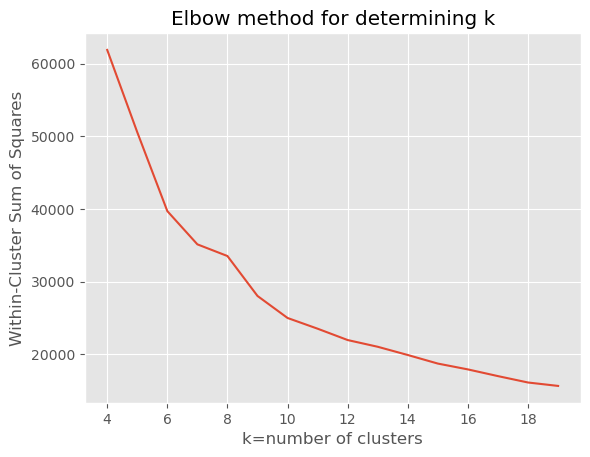

In [36]:
WCSS=[]
for i in range(4,20):
  kmeans=KMeans(n_clusters=i,init='k-means++')
  kmeans.fit(final_data[scaled_feature_columns].sample(50000))
  WCSS.append(kmeans.inertia_)
WCSS

plt.plot(range(4,20),WCSS);
plt.ylabel('Within-Cluster Sum of Squares')
plt.xlabel('k=number of clusters')
plt.title('Elbow method for determining k');

## Another Way to Visualize Clustering Performance
Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster. [source](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)


### Your Turn!
Try visualizing models with various values of `K`.

**Note**:  This visualization is quite expensive, so I recommend performing this using a sample of your original data.

For n_clusters = 2 The average silhouette_score is : 0.5207647532468264


InvalidIndexError: (slice(None, None, None), 0)

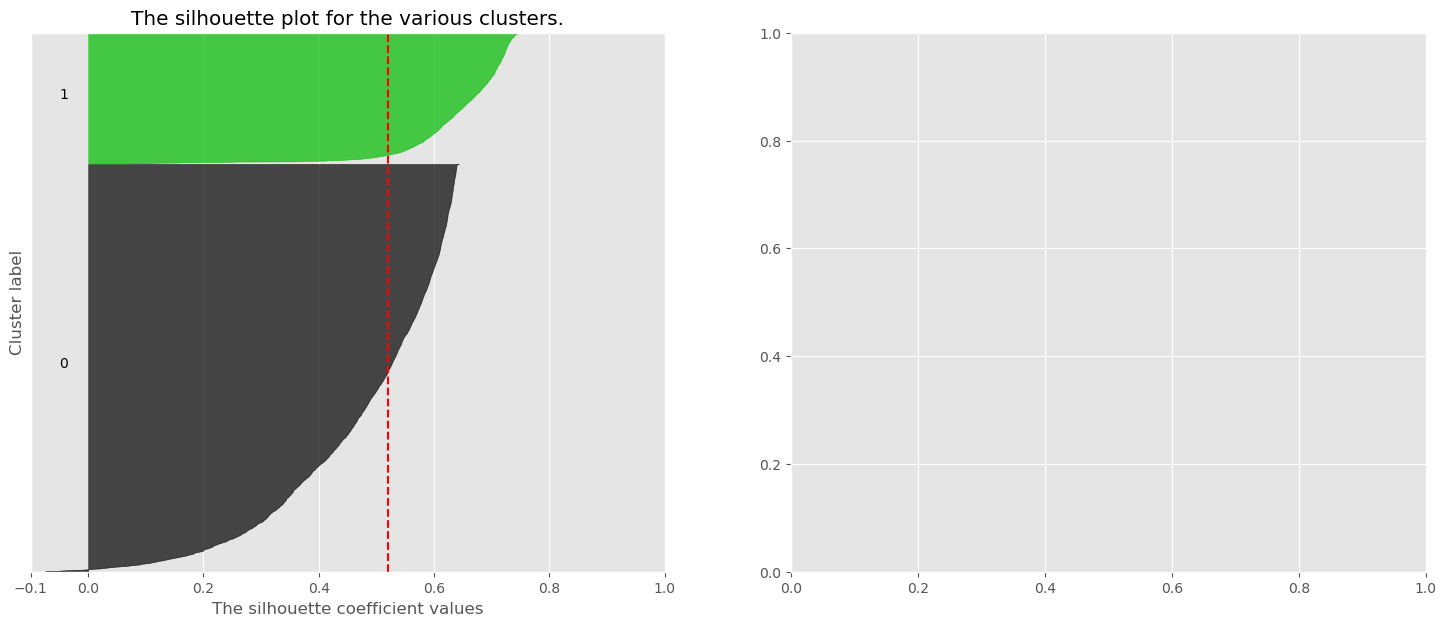

In [47]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans=KMeans(n_clusters=n_clusters,init='k-means++')
    X = final_data[scaled_feature_columns].sample(10000)
    cluster_labels = kmeans.fit_predict(X)

    # This gives a perspective into the density and separation of the formed
        # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )
    
        # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    
            ith_cluster_silhouette_values.sort()
    
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
    
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )
    
            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )
    
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )
    
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
    
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    
    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

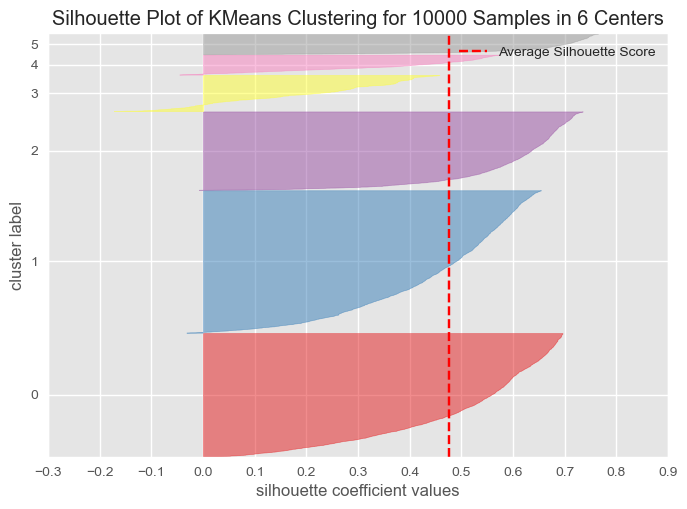

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10000 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [21]:
visualizer = SilhouetteVisualizer( KMeans(n_clusters=6, n_init=3))

visualizer.fit(final_data[scaled_feature_columns].sample(10000))
visualizer.show()

## Anomaly Detection using Clustering methods
Let's use a hierarchical clustering method to detect anomalies in a set of data points. The one we will use is called (agglomerative clustering)[https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html]. 

First we will create a dataset that only has 20 DGA rows and 1000 legit samples. Thus, there are 20 anomalies in this dataset that we know of. Then we will see if our clustering method can detect them. 

In [48]:
dga_data = pd.read_csv('../data/dga_features_final_df_domain.csv')
print(dga_data.isDGA.value_counts())

isDGA
dga      1000
legit    1000
Name: count, dtype: int64


In [49]:
is_dga = dga_data[dga_data['isDGA']=='dga'].sample(10)
not_dga = dga_data[dga_data['isDGA']=='legit']

In [50]:
print(len(is_dga))
print(len(not_dga))

10
1000


In [51]:
dga_anomaly_data = pd.concat([is_dga, not_dga])
dga_anomaly_data['isDGA'].value_counts()

isDGA
legit    1000
dga        10
Name: count, dtype: int64

In [52]:
dga_anomaly_data_domain = dga_anomaly_data
dga_anomaly_data = dga_anomaly_data.drop('domain',axis=1)

#### Now use this dataset in clustering

First we want to scale the data because it is clustering which means that distance is important and that is extremely sensitive to different scales. Use either the Standard Scaler or Min Max Scaler from sklearn to scale our data set.

In [53]:
dga_anomaly_data  = StandardScaler().fit_transform(dga_anomaly_data)

ValueError: could not convert string to float: 'dga'

Now that we have prepared the data, we can put it into a model. Call the Agglomerative Clustering model from sklearn and fit it to the data. name the model **agglomerative_clust**

In [ ]:
agglomerative_clust = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

# Your code here
agglomerative_clust = agglomerative_clust.fit(dga_anomaly_data)

# pull out the label of the cluster each point belongs to. 
labels_for_clusters = agglomerative_clust.labels_

This plot_dendrogram function will plot the dendrogram for the cluster model you just fitted to the data. 

In [24]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Use the plot_dendrogram function to plot the dendrogram. You an get lower and lower levels if you increase the value of **p**. Try plotting a few values of **p** to see the difference and notice what happens.

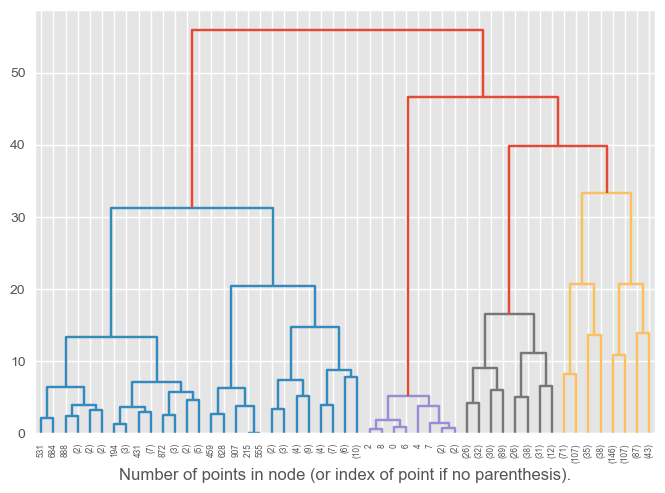

In [87]:
plot_dendrogram(agglomerative_clust, truncate_mode="level", p=5);
plt.xlabel("Number of points in node (or index of point if no parenthesis).");


Notice that in the plot there are some digits on the x-axis with no parenthesis. These are nodes that did not have more than 1 data point. We want to take a look at these because they are 'far' enough away from the rest of the data to warrant their own node, and thus could be an anomaly. 

Below, use the original pandas data frame to print the rows of the single nodes and see if these are our few DGAs. 

In [25]:
dga_anomaly_data_domain.iloc[0,:]

NameError: name 'dga_anomaly_data_domain' is not defined

In [71]:
dga_anomaly_data_domain.iloc[3,:]

isDGA                                       1
domain             15ihbm71utcnfa8dk1mmgoobl9
length                                     26
digits                                      7
entropy                              4.180833
vowel-cons                           0.357143
firstDigitIndex                             1
ngrams                             682.269402
Name: 3, dtype: object

In [90]:
dga_anomaly_data_domain.iloc[5,:]

isDGA                            1
domain             uyphoykvvmxetnf
length                          15
digits                           0
entropy                   3.640224
vowel-cons                    0.25
firstDigitIndex                  0
ngrams                  779.403541
Name: 970, dtype: object

In [89]:
dga_anomaly_data_domain.iloc[29,:]

isDGA                         0
domain             skidrowgames
length                       12
digits                        0
entropy                3.418296
vowel-cons                  0.5
firstDigitIndex               0
ngrams               1337.05303
Name: 1019, dtype: object

Another thing to note is just to look at the contents of the smallest cluster (depending on how small you think your anomalies are. IN this case our smallest cluster contains the DGAs. Thus, our model accurately pulled out the DGAs into their own 'anomaly' cluster. 

## DBSCAN
Another clustering method we can try is DBSCAN (http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).  Remember that the main tuning parameters for DBSCAN are:

* **epsilon (eps)**:  The minimum distance between two samples 
* **min_samples**:  The minimum number of samples needed to form a neighborhood

By default epsilon is 0.5 and the min_samples is 5. First, try DBSCAN with the default options.  If you use the `fit_predict()` function, you can save the results in a new column in your data.  

How did this compare with K-Means?  Given that you actually know what the data really is, how did DBSCAN do in terms of identifing meaningful clusters?  Look at the `dsrc` column and do `value_counts()` for the various neighhborhoods.  What did you notice?

Try again, but this time experiment with the values of epsilon and min_samples and see what DBSCAN comes up with. 

In [23]:
dbscan = DBSCAN(min_samples=50)

In [24]:
final_data['dbs_default'] = dbscan.fit_predict(final_data[scaled_feature_columns])

In [25]:
final_data['dbs_default'].value_counts()

 1    39301
 2     9973
 0     2500
-1      284
 4      259
 3      116
 5       45
Name: dbs_default, dtype: int64

In [26]:
final_data[final_data['dbs_default'] == 1 ]['dsrc'].value_counts()

cryptolocker    10000
necurs           9990
nivdort          9978
alexa            9330
gameoverdga         3
Name: dsrc, dtype: int64

In [27]:
final_data[final_data['dbs_default'] == 1 ][['dsrc','domain']].sample(10)

,dsrc,domain
9446,cryptolocker,xvbnapiywfagvt
23140,necurs,huwvtreromwta
2731,cryptolocker,hufqjcrmgchih
41248,nivdort,whomwhole
35529,nivdort,thesefeel
6953,cryptolocker,bdtakobikoni
5404,cryptolocker,xiuadnbellohhw
28650,necurs,ngqhqqbduvjkdr
38321,nivdort,dreamgrow
7461,cryptolocker,lligwhttuxyqir


In [28]:
final_data[final_data['dbs_default'] == -1 ]['dsrc'].sample(10)

50809      alexa
49624      alexa
51698      alexa
43531      alexa
52446      alexa
2405     bamital
46545      alexa
47868      alexa
52264      alexa
49046      alexa
Name: dsrc, dtype: object

In [29]:
final_data['domain'][final_data['dsrc'] == "nivdort"].sample(5)

40241    drinkvoice
42410     fairfruit
39274      rockslow
38547      gladjune
40724     headthrow
Name: domain, dtype: object

In [30]:
final_data[final_data['dbs_default'] == 2 ]['dsrc'].value_counts()

gameoverdga    9973
Name: dsrc, dtype: int64

In [31]:
final_data[final_data['dbs_default'] == 1 ]['dsrc'].value_counts()

cryptolocker    10000
necurs           9990
nivdort          9978
alexa            9330
gameoverdga         3
Name: dsrc, dtype: int64

In [32]:
final_data[final_data['dsrc'] == "cryptolocker"]['domain'].sample(10)

10649       wbirarkhsfgf
8792        ffkwsvsieexl
11876      gkjsqegicfuxs
7565       btahdqypypsbp
12072     xjlepuhmjvycjt
8145     gxaakkrvirymuuk
11432    qnvysekkbpwpnmo
3825        qmvuvtftlhws
7031        hgttabqebluy
5041        iyiwxusxdvke
Name: domain, dtype: object

In [33]:
final_data[final_data['dsrc'] == "necurs"]['domain'].sample(10)

32316          ptgctebbvohb
31865    vwhilgweujpuliijvs
26512     ksyaqkudmuorqdsnx
30930           kmtleqvxqvk
24248     rtatnpxrleuyjfvmr
27666     rlgawlqrvgkskeisa
24989            uegqqmllfr
22616          defellojyrqw
22599            jhkoqfmwjo
26324     vrdimsspkhpbyvwjo
Name: domain, dtype: object